# Trend: System identification

As the final step in the implementation of HMM-based logic in trend-following strategies, we need to figure out how to determine/approximate the parameters of $A and $B$ matrices from data. Thus far, we have buitl the HMM filters and smoothers based on an assumption that we have access to both the $A$ and $B$ matrices. However, in practice, this information will not be readily available, and thuis we will have to infer the parameters of the system before running any filtering.

The mechanism through which the parmeter estimation is performed is known as the Baum-Welch algorithm, which is a specific instance of an expectaion-maximization (EM) algorithm in the case of HMMs. In this algorithm, given an initial estimate of the system parameters, the Bayesian forward and backward estimation algorithms ca be use to iteratively improve the system parameter estimates until a desired level of convergence.

### Expectation

In the expectation step of the algorithm, we are calculating the expected values of several quantities along the sequence of observations, assuming a known (fixed) set of parameters $\theta$.  For the sake of clarity, we define the following notation:

$$ \alpha_i(t) = P(x_t | y^t, \theta) $$
$$ \beta_i(t) = P(x_t| y_{[t, T]}, \theta) $$
$$ \gamma_i(t) = P(x_t| y^T, \theta)$$

for the probabilities obtianed in the forward, backward, and smoothing algorithms respectively. Here, we have explicitly included the parameter vector $\theta$ which is the set of all system parameters, which in this case are the elements of the two matrices $A$ and $B$.

Now, to use the Baum-Welch algorithm, we define one new---previously unseen---term

$$ \xi_{ij}(t) = P(x_t, x_{t+1} | y^T, \theta) \equiv \frac{P(x_t, x_{t+1}, y^T | \theta)}{P(y^T | \theta)} $$
$$ = \frac{\alpha_i(t) A_{ij} \beta_j(t+1) \tilde{B}_j(y_{t+1})}{\sum_{k, w = 1}^N \alpha_k(t) a_{kw} \beta_w(t + 1)\tilde{B}_w(y_{t+1}) } $$

which is--although mathematically somewhat convoluted---the probability of being in states $i$ and $j$ at times $t, t+1$, given the entire observed sequence $y^T$ and the current parameter values.

### Maximization

Now, given these definitions, the parameter re-estimation (maximization step in the EM algorithm) involves making the following calculations:

- First, the initial state probability is updated
    $$ \pi_i^* = \gamma_i(t=1)$$
- Then, we update the elements of the hidden-state transition matrix (to the expected number of transitions from state $i\to j$ campared to the expected number of transitions away from state $i$, which includes self transitions)
    $$ a_{ij}^* = \frac{\sum_{t=0}^Txi_{ij}(t)}{\sum_{t=0}^T \gamma_i(t)} $$
- Then, we calculate
    $$ \tilde{B}_i(v_k) \equiv \frac{\sum_{t=0}^T 1_{y_t = v_k}\gamma_i(t)}{\sum_{t=0}^T \gamma_i(t)} $$
- Where the indicator function is unity of $y_t = v_k$ and zero otherwise, so that the expected number of times that the output observations have been equal to $v_k$ while in state $i$, over the total number of expected times of the system being in state $i$.

The essence of the Baum-Welch algorithm (and, in fact, any EM algorithm) is the repeated iteration of the expectation and maximization steps until a desired level of convergence is reached.

however, it is worth noting that this is not guaranteed to be a convex optimization, and thus both overfitting and local optima can be seen to occur in these problems, so caution should be used in iterating to find parameters.

In the code below, we will build the logic for the Baum-Welch EM algorithm based on previous definitions for the Bayesian forward, backward, and smoothing algorithms



In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', palette="hls")

from hidden.dynamics import HMM
from pathlib import Path

proj_dir = Path().resolve().parents[0]
plot_dir = os.path.join(proj_dir, "/results/system_identification")

In [5]:
# Okay, so first lets define a set of `true` matrices for the dynamics, as well
# as a set of `estimated` matrices, representing our initial guesses

# Consider a 2-state system with symmetric transition probabilities and
# and emmission probability error rates of 0.2, and 0.2
hmm = HMM(2, 2)
hmm.init_uniform_cycle(0.2, 0.2)

print(f'State transition matrix --> {hmm.A}\nEmmission matrix --> {hmm.B}')

State transition matrix --> [[0.8 0.2]
 [0.2 0.8]]
Emmission matrix --> [[0.8 0.2]
 [0.2 0.8]]


In [7]:
# Now, we can generate a long series of observations and states from this model
hmm.run_dynamics(n_steps=500)

# and then pull off the states and observations
state = hmm.get_state_ts()
obs = hmm.get_obs_ts()

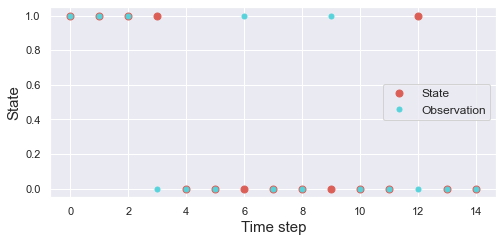

In [18]:
# Which can be plotted for the sake of cpmpleteness
Pal = sns.color_palette("hls", 2)
_, ax = plt.subplots(1, 1, figsize=(8, 3.5))
ax.plot(state[:15], 'o', markersize=7, color=Pal[0], label="State")
ax.plot(obs[:15], 'o', markersize=5, color=Pal[1], label="Observation")

ax.legend(fontsize=12)
ax.set_xlabel(r"Time step", fontsize=15)
ax.set_ylabel(r"State", fontsize=15)
plt.show()

In [ ]:
# Now we want to add in our forward (Bayesian filter), backward, and forward-backward (Bayesian smoother) probabilities

def bayesian_smoother(A, obs):
    pass

def bayesian_back(A, obs):
    pass

def bayesian_smoother(A, obs):
    pass